# COVID-19 Infection Trajectory for Dane County, WI
## RESEARCH

### 1. SIR ((Susceptible, Infected, and Recovered) BASIC MODEL OF EPIDMIOLOGY, w/ w/o vital dynamics)
#### N=S+I+R
### 2. SEIR ((Susceptible,  Exposed, Infected and Recovered), DERIVATIVE OF SIR)
#### N=S+E+I+R
### 3. Regression Analysis
#### Linear,logistic,polynomial,poisson,etc
### 4. People Over Tests
#### Pairs a numerator that excludes retests (people) with a denominator that includes retests (tests). In many jurisdictions, this method is the only option based on the available data. 
### 5. Tests Over Tests 
#### Uses a numerator and denominator that both include retests, which makes it helpful in understanding how many tests are being done compared to the number of infections in a given area. 
### 6. People Over People
#### Uses a numerator and denominator that both exclude retests, and is therefore especially helpful in validating case count growth (or declines) in a given area. 
### 7. Confirmed new cases per Day  w/ 7 day rolling avg

In [1]:
import pandas as pd
import csv
import sqlite3
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import numpy as np
import re

%matplotlib inline 

matplotlib.rcParams["font.size"] = 20 #store rc settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

county_data = pd.read_csv("COVID-19_Historical_Data_by_County.csv")
county_data_V2 = pd.read_csv("COVID-19_Historical_Data_by_County_V2.csv")

conn_01 = sqlite3.connect('COVID-19_Historical_Data_by_County.db')
conn_02 = sqlite3.connect('COVID-19_Historical_Data_by_County_V2.db')

county_data.to_sql("county_data", conn_01, if_exists="replace", index=False)
county_data_V2.to_sql("county_data_V2", conn_02, if_exists="replace", index=False)

def qry(sql,conn_01):
    return pd.read_sql(sql, conn_01)

def qry2(sql,conn_02):
    return pd.read_sql(sql, conn_02)

def lookup(data,String):    
    for row in data:
        if String in row:
            return row

### Index Definitions

In [2]:
reader_index = csv.reader(open('index.csv'))
l=[]
for row in reader_index:
    l.append(row)
l_1=[]
for row in l:
    x = ' '.join(map(str,row))
    l_1.append(x)

In [3]:
lookup(l_1,"POS_NEW")

'POS_NEW: Number of people who had confirmed cases of COVID-19 newly reported since the previous day. Each person can only be reported as a confirmed case once.'

In [4]:
county_data.head(10)

,GEOID,GEO,NAME,DATE,POSITIVE,POS_NEW,POS_7DAYAVG,NEGATIVE,NEG_NEW,NEG_7DAYAVG,...,DTH_WHT,DTH_MLTOTH,DTH_UNK,DTH_E_HSP,DTH_E_NHSP,DTH_E_UNK,POS_HC_Y,POS_HC_N,POS_HC_UNK,OBJECTID
0,55001,County,Adams,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,55003,County,Ashland,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,55005,County,Barron,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
3,55007,County,Bayfield,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,55009,County,Brown,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
5,55011,County,Buffalo,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
6,55013,County,Burnett,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
7,55015,County,Calumet,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
8,55017,County,Chippewa,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
9,55019,County,Clark,2020/03/15 19:00:00+00,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [5]:
# QUERY
DANE_QUERY = qry("""
SELECT DATE, POSITIVE, POS_NEW, POS_7DAYAVG, NEGATIVE, NEG_NEW, NEG_7DAYAVG, TEST_NEW
FROM county_data
WHERE NAME="Dane" 
GROUP BY DATE
""",conn_01)

MILWAUKEE_QUERY = qry("""
SELECT POSITIVE as total_positive_cases,NAME as County
,DATE,POS_7DAYAVG
FROM county_data
WHERE NAME="Milwaukee"
""",conn_01)

DANE_QUERY_V2 = qry2("""
SELECT RptDt,POS_NEW_PROB, POS_7DAYAVG_PROB, TESTS_NEW , NEG_NEW, POS_NEW_CONF
FROM county_data_V2
WHERE GEOName="Dane" 
GROUP BY DATE
""",conn_02)

date_col = DANE_QUERY['DATE']

count =0
for i in range(len(date_col)):
    date_col.loc[i] = date_col[i][:10]
    if date_col.loc[i][:4] == "2020":
        count+=1

df_2020 = DANE_QUERY.loc[:291]
df_2021 = DANE_QUERY.loc[292:]

c:\users\trance\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
DANE_QUERY.tail(7)

,DATE,POSITIVE,POS_NEW,POS_7DAYAVG,NEGATIVE,NEG_NEW,NEG_7DAYAVG,TEST_NEW
565,2021/10/01,53166,203.0,130.00,407153.0,1024.0,787.00,1227.0
566,2021/10/02,53319,153.0,129.43,408171.0,1018.0,799.29,1171.0
567,2021/10/03,53388,69.0,131.43,408542.0,371.0,759.14,440.0
568,2021/10/04,53489,101.0,139.14,409168.0,626.0,778.57,727.0
569,2021/10/05,53729,240.0,151.86,409850.0,682.0,784.29,922.0
570,2021/10/06,53893,164.0,150.00,410816.0,966.0,801.14,1130.0
571,2021/10/07,54011,118.0,149.71,411541.0,725.0,773.14,843.0


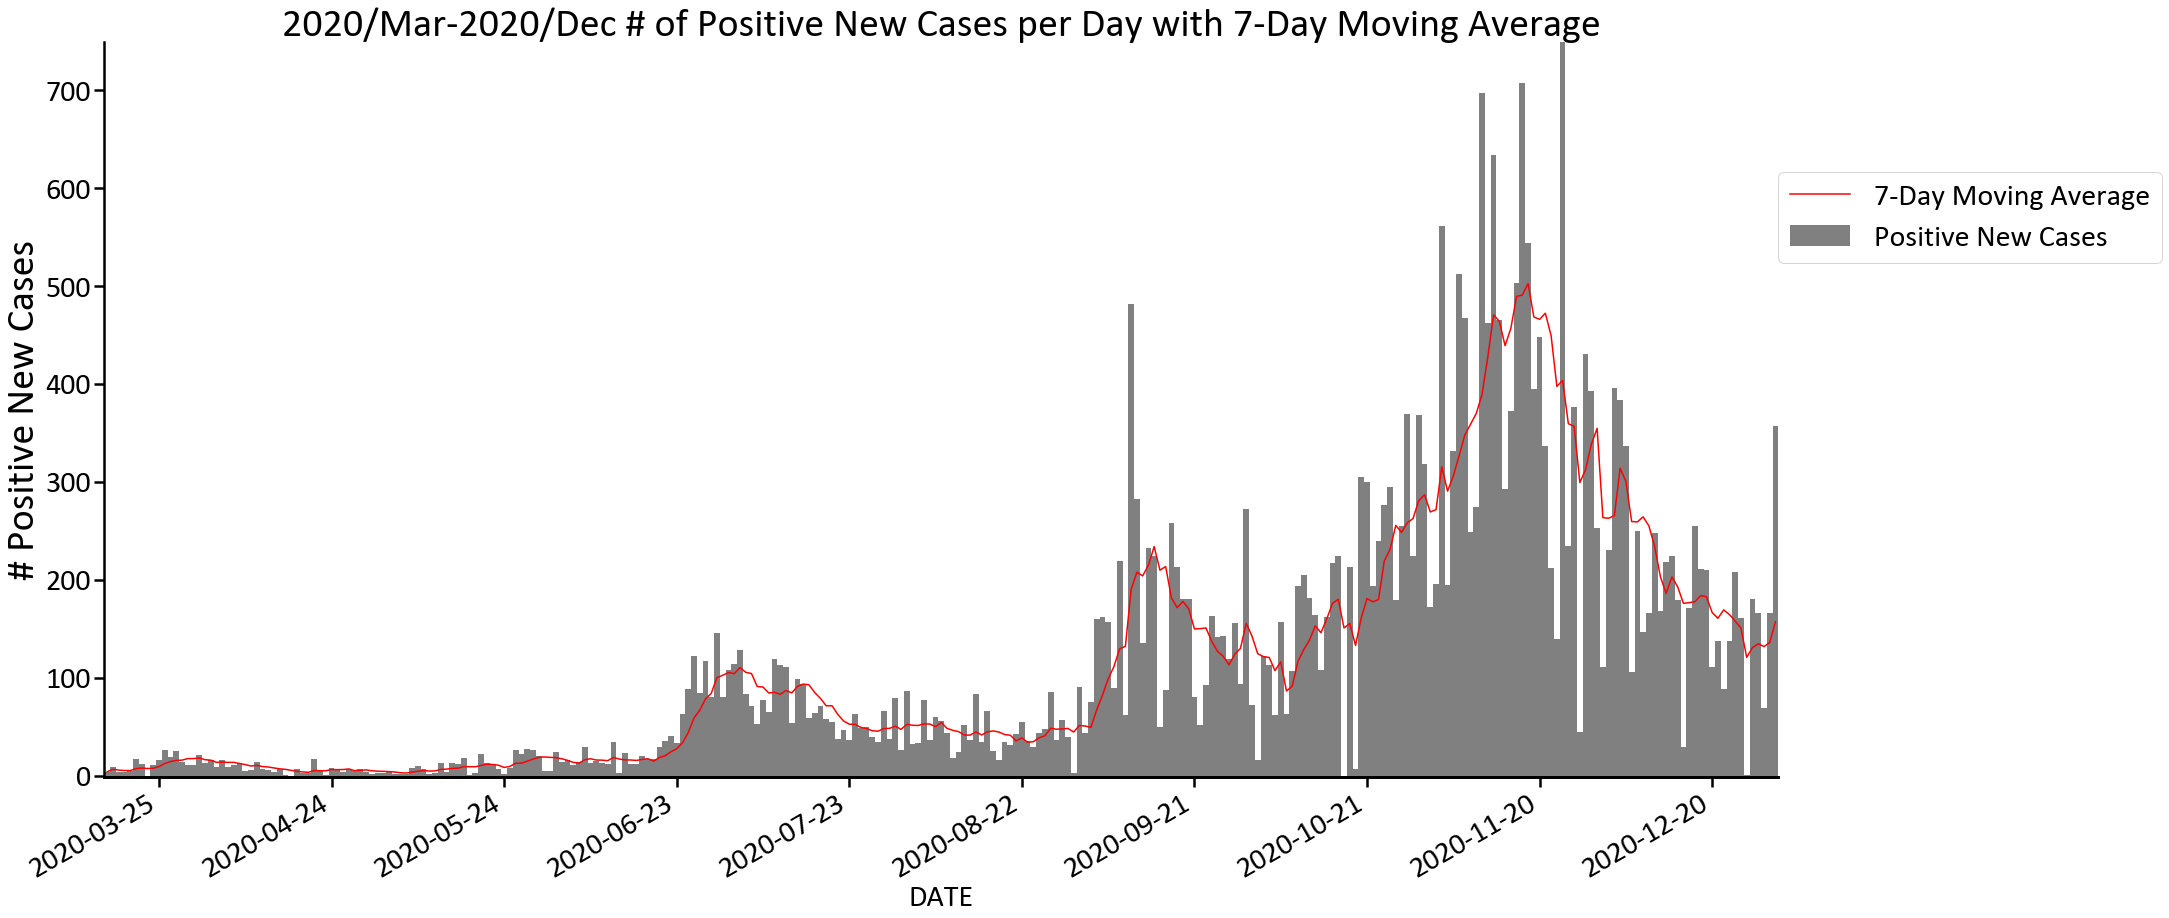

In [7]:
fig,ax=plt.subplots(figsize=(30,15))

days_2020 = mdates.drange(dt.datetime(2020, 3, 15),dt.datetime(2020, 3, 15) + dt.timedelta(days=292),dt.timedelta(days=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))

ax.bar(days_2020,df_2020["POS_NEW"],width=1,color="grey",label="Positive New Cases")
ax.plot(days_2020, df_2020["POS_7DAYAVG"],color="red",label="7-Day Moving Average")

ax.set_title("2020/Mar-2020/Dec # of Positive New Cases per Day with 7-Day Moving Average",fontsize=40)
ax.set_ylabel("# Positive New Cases",fontsize=40)
ax.set_xlabel("DATE",fontsize=30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3.0)
ax.spines["left"].set_linewidth(2.5)

ax.tick_params(axis="both", which="major", labelsize=40,width=2.5, length=10)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

ax.legend(loc=[1,0.7], fontsize=30)

plt.gcf().autofmt_xdate()
plt.show()

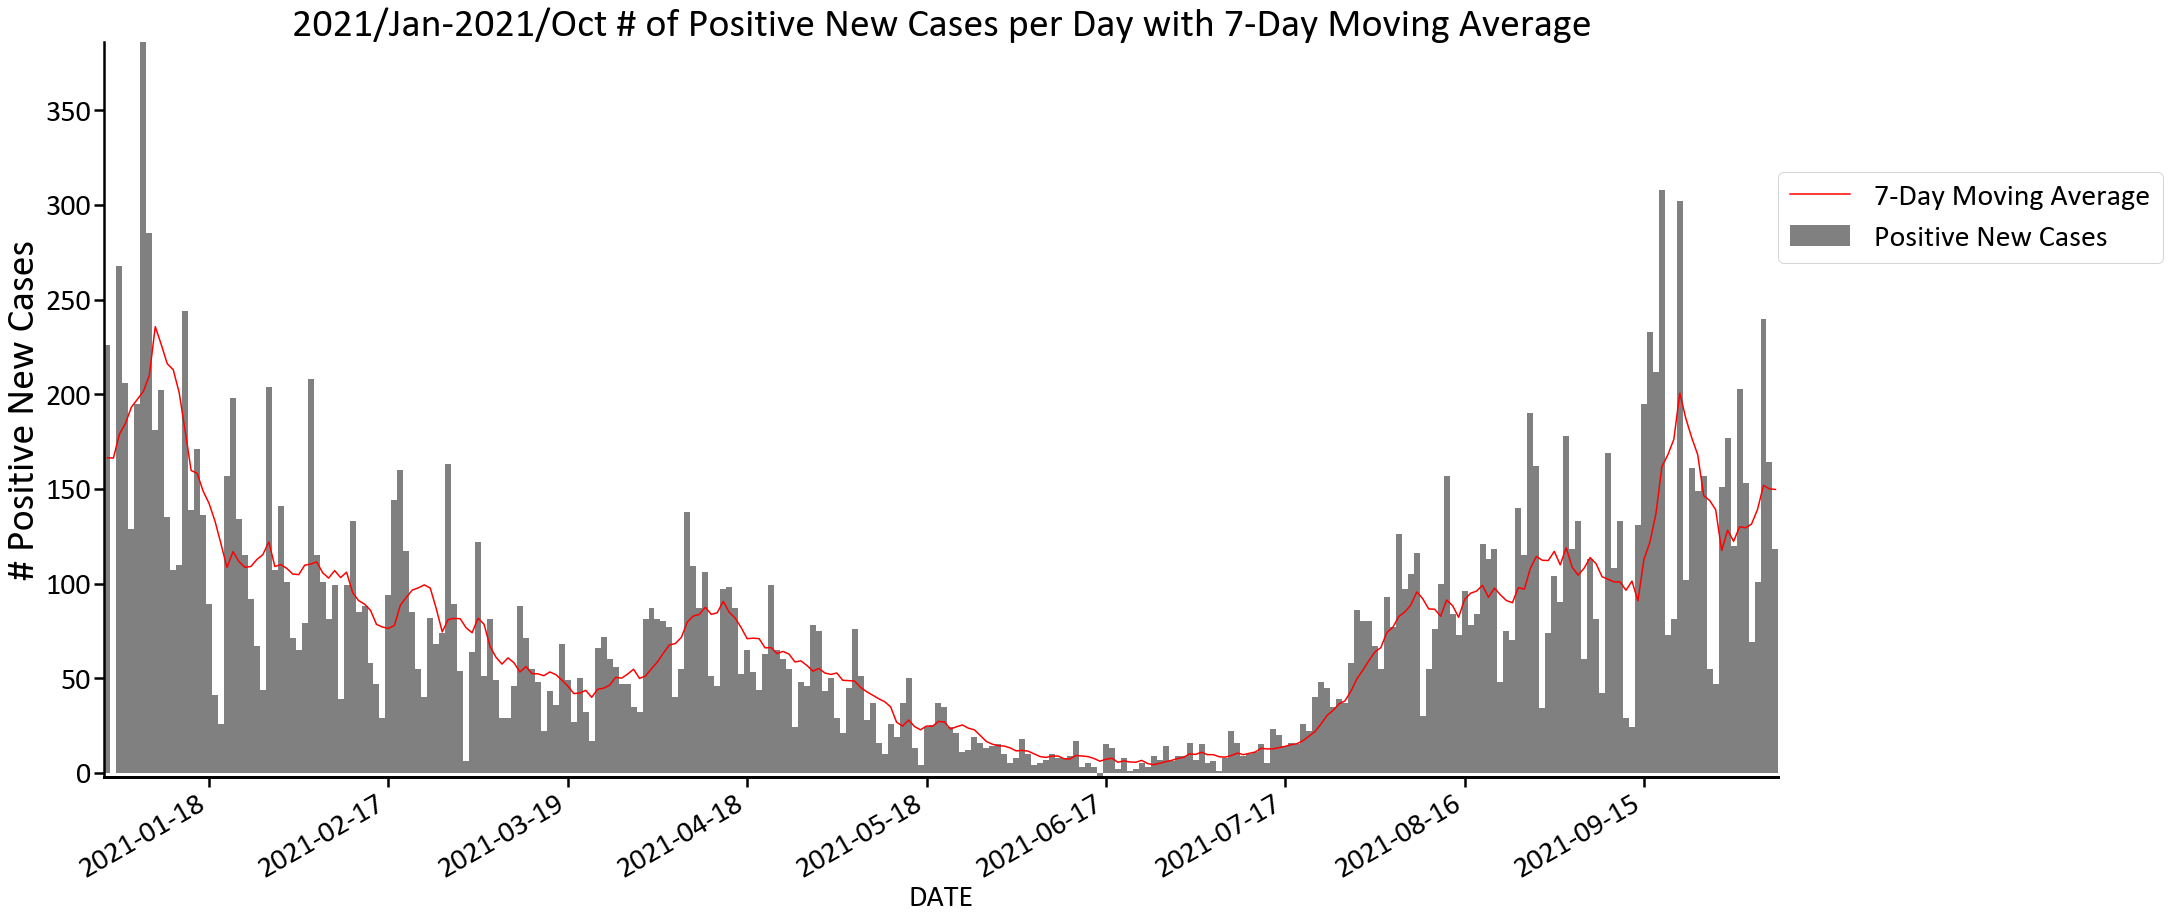

In [8]:
fig,ax=plt.subplots(figsize=(30,15))

days_2021 = mdates.drange(dt.datetime(2021, 1, 1),dt.datetime(2021, 1, 1) + dt.timedelta(days=280),dt.timedelta(days=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))

ax.bar(days_2021,df_2021["POS_NEW"],width=1,color="grey",label="Positive New Cases")
ax.plot(days_2021, df_2021["POS_7DAYAVG"],color="red",label="7-Day Moving Average")

ax.set_title("2021/Jan-2021/Oct # of Positive New Cases per Day with 7-Day Moving Average",fontsize=40)
ax.set_ylabel("# Positive New Cases",fontsize=40)
ax.set_xlabel("DATE",fontsize=30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3.0)
ax.spines["left"].set_linewidth(2.5)

ax.tick_params(axis="both", which="major", labelsize=40,width=2.5, length=10)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

ax.legend(loc=[1,0.7], fontsize=30)

plt.gcf().autofmt_xdate()
plt.show()

In [9]:
df_2021['POS_NEW'][162:]

454     17.0
455      3.0
456      5.0
457      3.0
458     -2.0
       ...  
567     69.0
568    101.0
569    240.0
570    164.0
571    118.0
Name: POS_NEW, Length: 118, dtype: float64

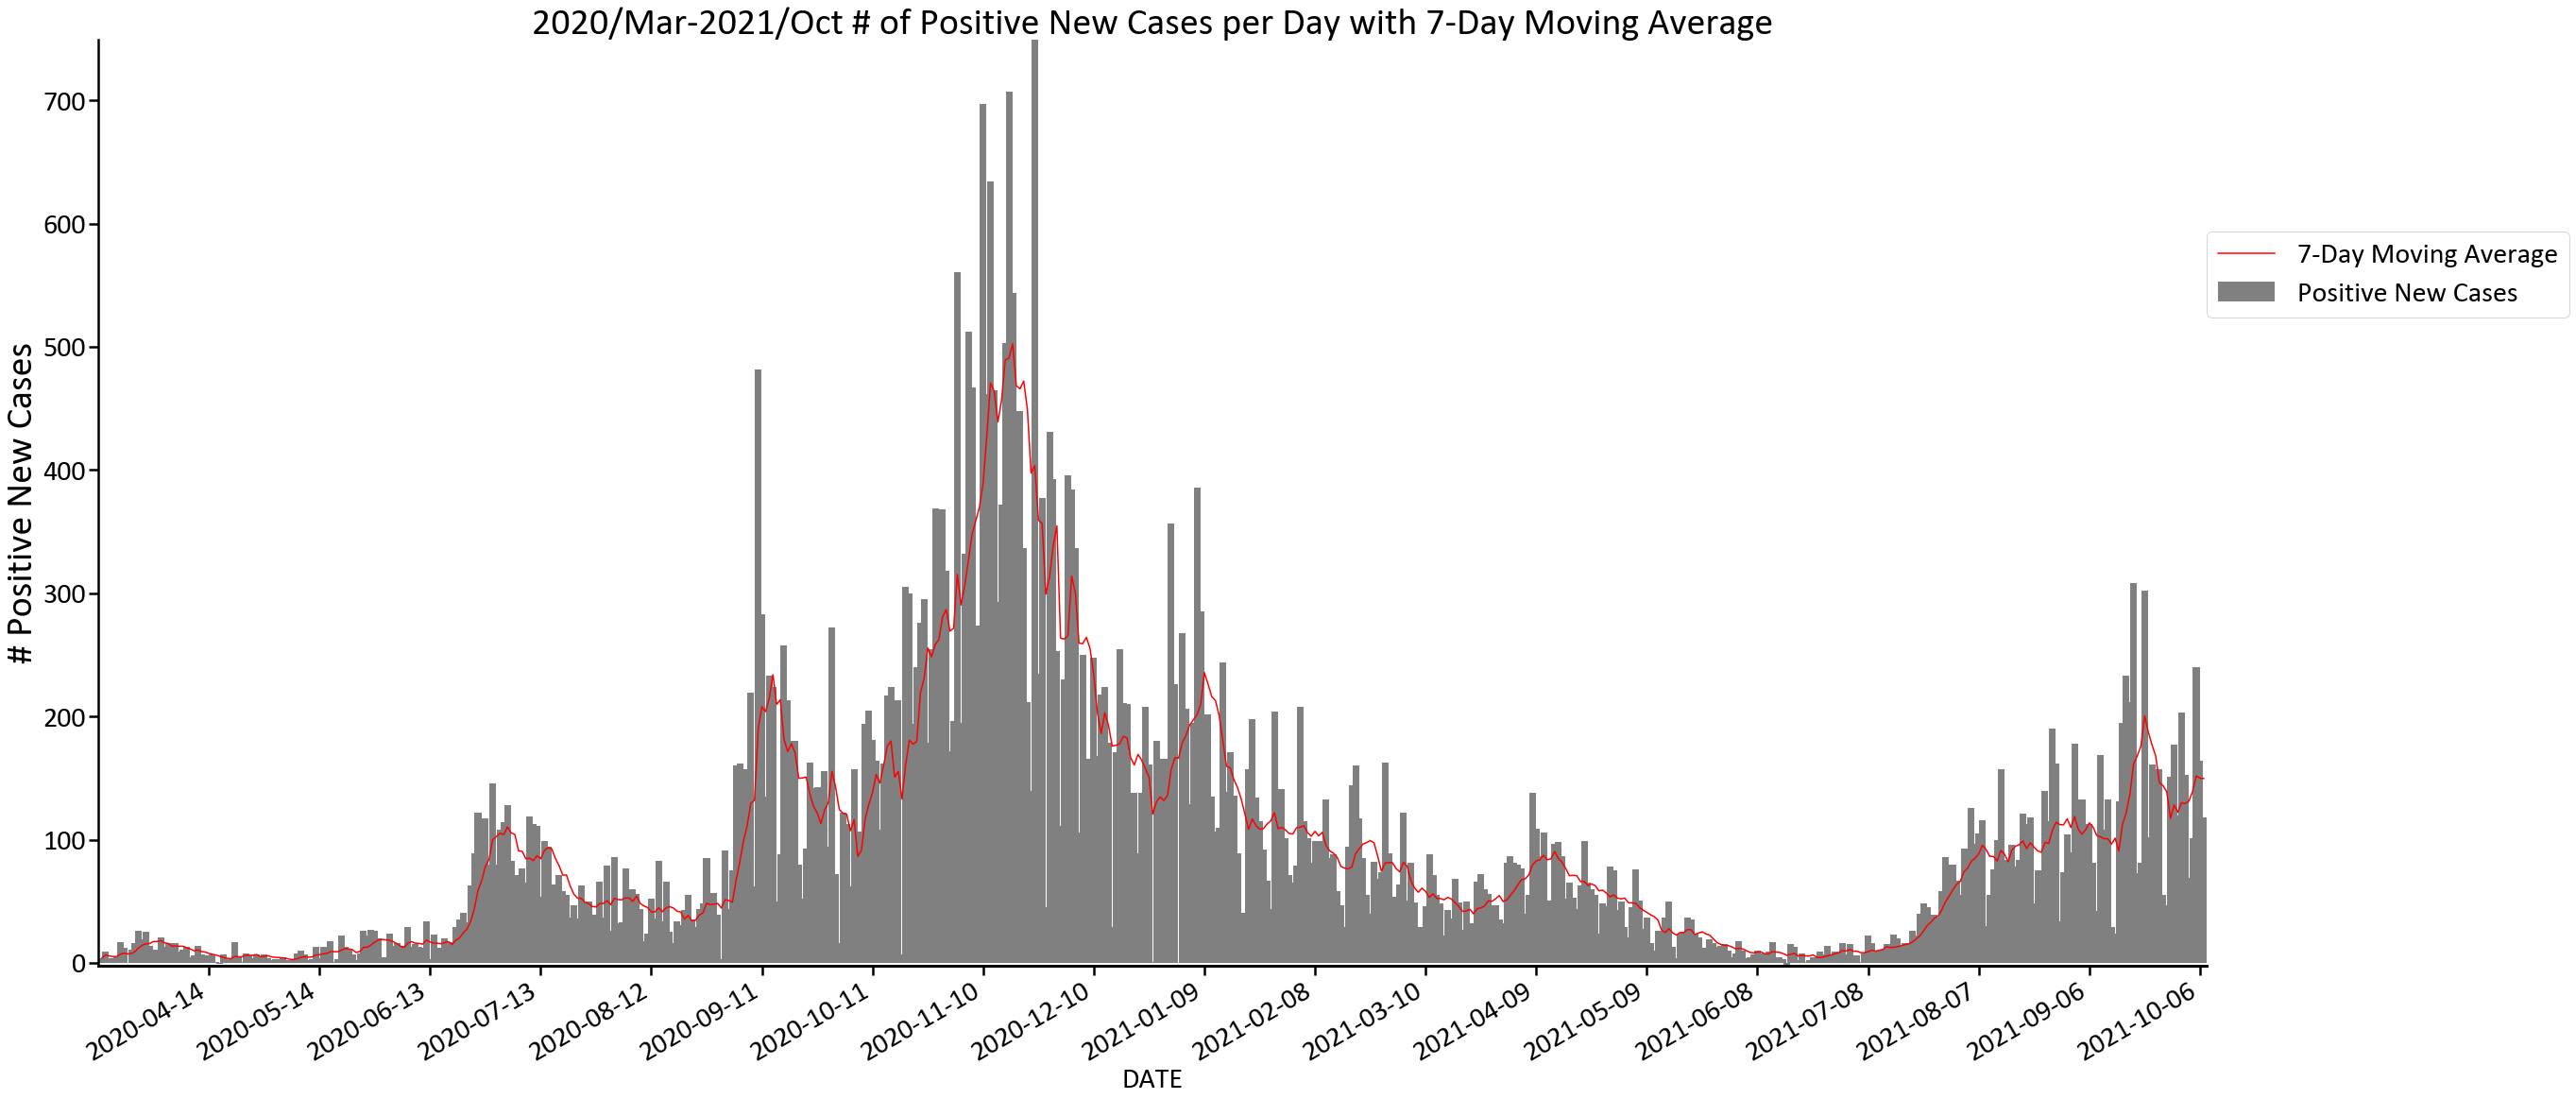

In [10]:
fig,ax=plt.subplots(figsize=(40,20))

days_tot = mdates.drange(dt.datetime(2020, 3, 15),dt.datetime(2020, 3, 15) + dt.timedelta(days=572),dt.timedelta(days=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))

ax.bar(days_tot,DANE_QUERY["POS_NEW"],width=1.8,color="grey",label="Positive New Cases")
ax.plot(days_tot, DANE_QUERY["POS_7DAYAVG"],color="red",label="7-Day Moving Average")

ax.set_title("2020/Mar-2021/Oct # of Positive New Cases per Day with 7-Day Moving Average",fontsize=40)
ax.set_ylabel("# Positive New Cases",fontsize=40)
ax.set_xlabel("DATE",fontsize=30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3.0)
ax.spines["left"].set_linewidth(2.5)

ax.tick_params(axis="both", which="major", labelsize=40,width=2.5, length=10)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

ax.legend(loc=[1,0.7], fontsize=30)

plt.gcf().autofmt_xdate()
plt.show()

In [11]:
def rolling_avg_pred(intervals=None):
    df_pred=DANE_QUERY["POS_NEW"].rolling(intervals).mean()
    return df_pred

In [12]:
def predict(intervals, predict_days):
    i=0
    df = pd.DataFrame(rolling_avg_pred(intervals))
    while i <= predict_days:
        x = df.tail(intervals).mean()
        df = df.append(x,ignore_index =True)
        i+=1
    return df

In [13]:
def daily_cases_prediction(intervals, predict_days):
    df_pos_pred=pd.DataFrame(DANE_QUERY["POS_NEW"])
    return df_pos_pred

In [14]:
def plot_prediction(intervals,predict_days):
    
    prediction=predict(intervals,predict_days)
    
    fig,ax=plt.subplots(figsize=(40,20))
    
    days_tot = mdates.drange(dt.datetime(2020, 3, 15),dt.datetime(2020, 3, 15) + dt.timedelta(days=572+predict_days+1),dt.timedelta(days=1))
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    
    ax.plot(days_tot, prediction ,color="red",label= str(intervals) + "-Day Moving Average")
    
    ax.set_title("2020/Mar-2021/Oct "+ str(predict_days) +" days" + " # of Positive New Cases per Day with " 
                 + str(intervals)"-Day Moving Average",fontsize=40)
    ax.set_ylabel("# Positive New Cases",fontsize=40)
    ax.set_xlabel("DATE",fontsize=30)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3.0)
    ax.spines["left"].set_linewidth(2.5)

    ax.tick_params(axis="both", which="major", labelsize=40,width=2.5, length=10)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)

    ax.legend(loc=[1,0.7], fontsize=30)

    plt.gcf().autofmt_xdate()
    return ax

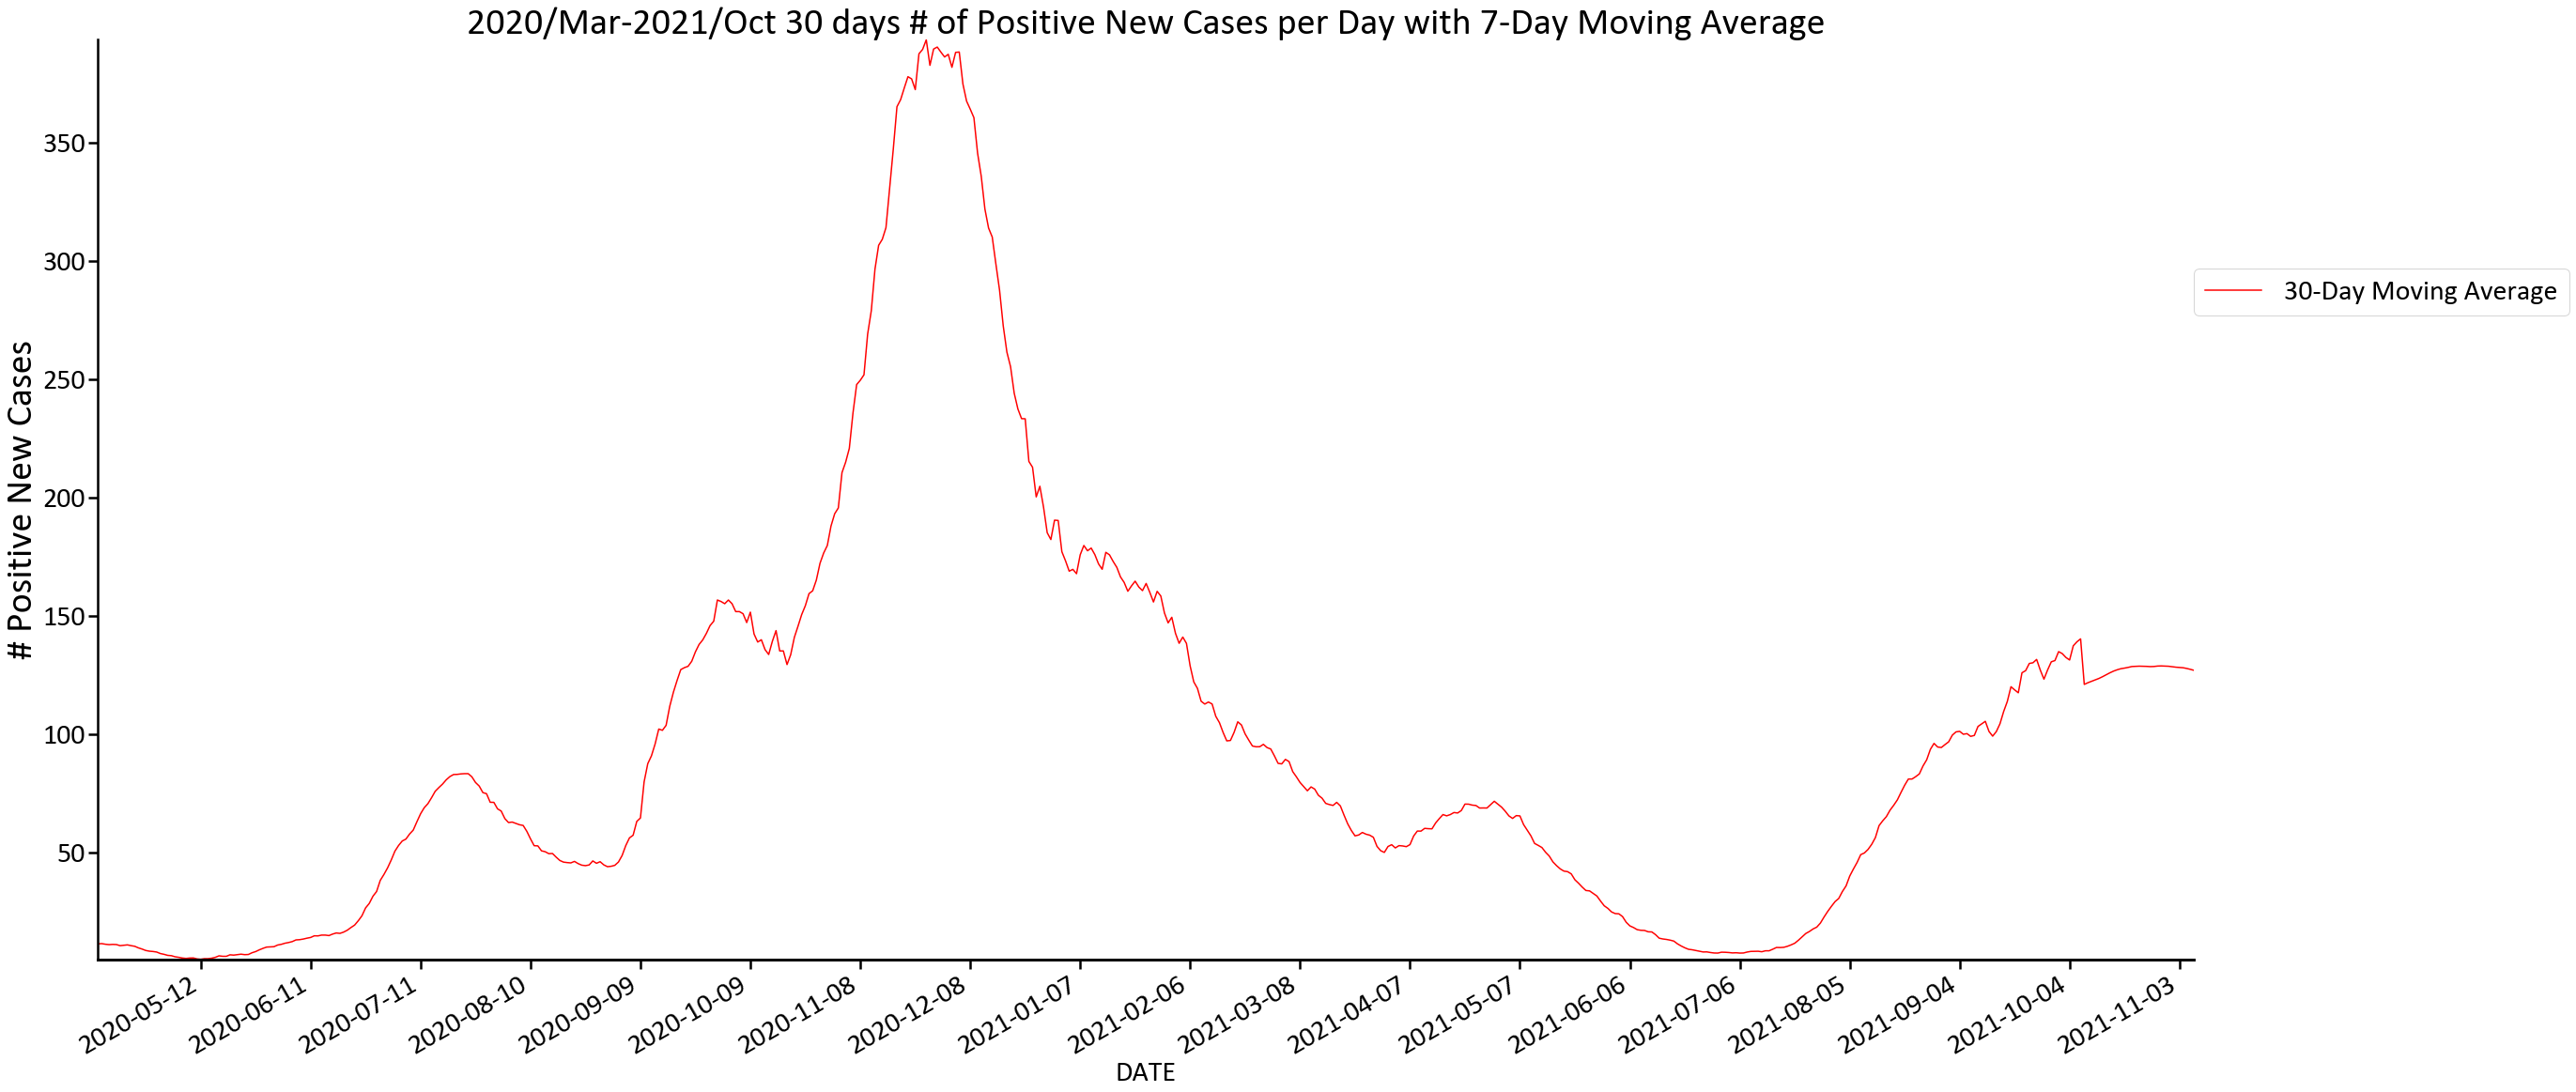

In [16]:
plot_prediction(30,30)